In [74]:
import pandas as pd
import json
from datetime import timedelta

In [2]:
with open("data/resnet-age-scores.json") as fh:
    scores = json.load(fh)

In [15]:
scores_df = pd.DataFrame.from_dict(scores, orient="index", columns = ['age_pred'])
scores_df = scores_df.reset_index().rename(columns={'index': 'study_id'})
scores_df.study_id = scores_df.study_id.astype('int64')
scores_df = scores_df.set_index("study_id")

In [62]:
dat = pd.read_csv('data/outcome-results.csv')

In [67]:
for col in [x for x in dat.columns if x.find("time") > 0]:
    dat[col] = pd.to_datetime(dat[col])

In [68]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76330 entries, 0 to 76329
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            76330 non-null  int64         
 1   hadm_id               76330 non-null  int64         
 2   stay_id               76330 non-null  int64         
 3   gender                76330 non-null  object        
 4   admission_age         76330 non-null  int64         
 5   admittime             76330 non-null  datetime64[ns]
 6   dischtime             76330 non-null  datetime64[ns]
 7   icu_intime            76330 non-null  datetime64[ns]
 8   icu_outtime           76330 non-null  datetime64[ns]
 9   hospital_expire_flag  76330 non-null  int64         
 10  study_id              76330 non-null  int64         
 11  ecg_time              76330 non-null  datetime64[ns]
 12  ecg_order             76330 non-null  int64         
dtypes: datetime64[ns

In [69]:
stays = dat.groupby('stay_id').agg({'ecg_order': 'max'})
keep_stays = stays[stays > 1].index

In [70]:
dat = dat[dat.stay_id.isin(keep_stays)]

In [71]:
dat = dat.join(scores_df, on = "study_id")

In [72]:
dat['age_delta'] = dat['age_pred'] - dat['admission_age']

In [79]:
dat['ecg_delta'] = (dat['ecg_time'] - dat['icu_intime']) / timedelta(hours=1)

In [80]:
import seaborn as sns

In [90]:
import numpy as np
#np.random.random_sample(, )
sample_stays = np.random.choice(dat.stay_id.unique(), 250)
figure_df = dat[dat.stay_id.isin(sample_stays)]

<Axes: xlabel='ecg_delta', ylabel='age_delta'>

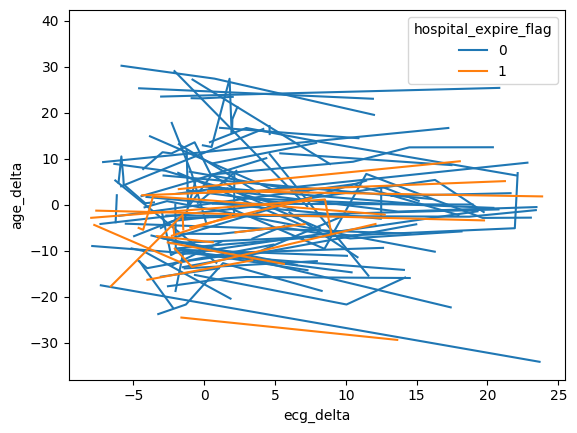

In [91]:
sns.lineplot(data=figure_df, x='ecg_delta', y='age_delta', hue='hospital_expire_flag', units='stay_id', estimator=None)

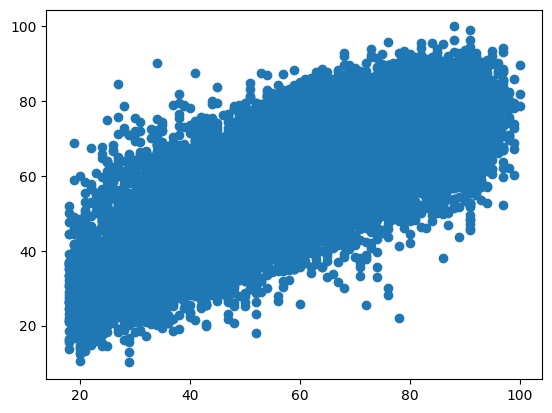

In [35]:


plt.scatter(dat.admission_age, dat.age_pred)

In [41]:
dat['age_delta_quant'] = pd.qcut(dat['age_delta'], q = 10)

In [49]:
dat['icu_mort'] = (dat['icu_outtime'] >= dat['dischtime']) & (dat['hospital_expire_flag'] == 1)

In [50]:
dat.groupby('age_delta_quant').agg({'hospital_expire_flag': 'mean', 'icu_mort': 'mean'})

,hospital_expire_flag,icu_mort
age_delta_quant,,
"(-56.05, -15.19]",0.170539,0.117492
"(-15.19, -10.745]",0.139413,0.088338
"(-10.745, -7.537]",0.130235,0.083973
"(-7.537, -4.732]",0.121876,0.082858
"(-4.732, -2.06]",0.107213,0.064898
"(-2.06, 0.615]",0.114862,0.074529
"(0.615, 3.563]",0.096032,0.062925
"(3.563, 7.023]",0.100175,0.069049
"(7.023, 11.976]",0.089235,0.062267
